This script sets your Google Drive credentials and the target folder ID, creates local folders for downloads and graphs, and installs any missing libraries. It then connects to Google Drive, searches the folder and all subfolders, and picks only .txt log files whose names include “LOG”, “PSP”, and “UTC”. Matching files are downloaded to the local cache (skipping ones you already have). Finally, it prints how many log files were found.

In [41]:
# ============================================================================
# AIR QUALITY DATA ANALYSIS - 
# ============================================================================

import os
from pathlib import Path
import sys
import subprocess
from io import StringIO
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# STEP 1: BASIC SETUP
# ============================================================================

import os
from pathlib import Path
import sys

# Search for credentials in multiple locations (for team flexibility)
possible_credential_paths = [
    Path.home() / "capstone_credentials.json",  # Recommended location (~/capstone_credentials.json)
    Path.cwd() / "capstonefall2025-d459579c25fc.json",  # Only works locally (NOT in repo)
    Path(os.getenv("CAPSTONE_SA_JSON", "")),  # Optional environment variable
]

credentials_file = None
for path in possible_credential_paths:
    if path.exists():
        credentials_file = path
        print(f"Using credentials: {path}")
        break

if not credentials_file:
    raise FileNotFoundError(
        "Credentials not found!\n\n"
        "Please:\n"
        "1. Get 'capstonefall2025-XXXXX.json' from the team (via Slack/email)\n"
        "2. Save it to: ~/capstone_credentials.json\n"
        "3. Make sure it's NOT in the Git repo folder\n"
        "4. Re-run this cell"
    )

drive_folder_id = "1YNujfIm14j_lMgDodoV8cvQksWZu_gdy"

os.environ["CAPSTONE_SA_JSON"] = str(credentials_file)
os.environ["CAPSTONE_FOLDER_ID"] = drive_folder_id

print("Working directory:", Path.cwd())

# ============================================================================
# STEP 2: INSTALL REQUIRED LIBRARIES
# ============================================================================

try:
    import pydrive2
except:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pydrive2", "--quiet"])

try:
    from oauth2client.service_account import ServiceAccountCredentials
except:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "oauth2client", "--quiet"])
    from oauth2client.service_account import ServiceAccountCredentials

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

# ============================================================================
# STEP 3: CONNECT TO GOOGLE DRIVE
# ============================================================================

def login_to_drive(credentials_path):
    """Connect to Google Drive using service account credentials"""
    if not Path(credentials_path).exists():
        raise FileNotFoundError(f"Credentials file not found: {credentials_path}")
    
    scopes = ["https://www.googleapis.com/auth/drive.readonly"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(credentials_path, scopes)
    
    auth = GoogleAuth()
    auth.credentials = creds
    return GoogleDrive(auth)

# ============================================================================
# STEP 4: FIND FILES IN GOOGLE DRIVE 
# ============================================================================

def find_all_log_files_in_folder(drive, folder_id):
    """Find all air quality log files in Google Drive (without downloading)"""
    
    FOLDER_TYPE = "application/vnd.google-apps.folder"
    folders_to_check = [folder_id]
    log_files = []
    
    while folders_to_check:
        current_folder = folders_to_check.pop()
        
        # Find subfolders
        subfolders = drive.ListFile({
            'q': f"'{current_folder}' in parents and mimeType='{FOLDER_TYPE}' and trashed=false"
        }).GetList()
        
        for folder in subfolders:
            folders_to_check.append(folder['id'])
        
        # Find files
        files = drive.ListFile({
            'q': f"'{current_folder}' in parents and mimeType!='{FOLDER_TYPE}' and trashed=false"
        }).GetList()
        
        for file_info in files:
            filename = file_info.get("name") or file_info.get("title")
            
            if not filename:
                continue
            
            # Check if this is a log file we want
            filename_upper = filename.upper()
            is_log_file = (filename_upper.endswith(".TXT") and 
                          "LOG" in filename_upper and 
                          "PSP" in filename_upper and 
                          "UTC" in filename_upper)
            
            if is_log_file:
                log_files.append({
                    'id': file_info['id'],
                    'name': filename,
                    'file_obj': file_info
                })
    
    return sorted(log_files, key=lambda x: x['name'])

Using credentials: /home/jovyan/capstone_credentials.json
Working directory: /home/jovyan/Capstone/Air_Q


This part of the code provides helper functions to make the raw log files usable. First, it looks for the section called “SAMPLE LOG”, finds the column headers (like DateTimeUTC), and loads the data into a pandas DataFrame. Any error codes such as -9999 are turned into missing values so they don’t break the analysis. The code then tries different ways to figure out the timestamps (from UTC, UnixTime, or local time) and to identify the device ID (from the folder name, filename, or file text). It also estimates the start time of the measurement either from the log summary, the first timestamp, or the filename, and formats both the date and the hour into readable labels.


In [42]:
# ============================================================================
# STEP 5: HELPER FUNCTIONS TO READ AND PROCESS DATA
# ============================================================================

def read_air_quality_log_from_drive(drive_file_info, drive):
    """Read an air quality log file directly from Google Drive (in-memory)"""
    
    # Get file content directly into memory
    file_obj = drive.CreateFile({'id': drive_file_info['id']})
    content = file_obj.GetContentString()
    
    # Split into lines
    lines = content.splitlines()
    
    # Find where the data table starts (marked by "SAMPLE LOG")
    try:
        sample_log_line = lines.index("SAMPLE LOG")
    except ValueError:
        raise RuntimeError(f"'SAMPLE LOG' not found in {drive_file_info['name']}")
    
    # Find the column headers (contains "DateTimeUTC")
    header_line = None
    for i in range(sample_log_line + 1, min(sample_log_line + 25, len(lines))):
        if "DateTimeUTC" in lines[i]:
            header_line = i
            break
    
    if header_line is None:
        raise RuntimeError(f"Column headers not found in {drive_file_info['name']}")
    
    # Extract data starting after the units line
    data_start = header_line + 2
    csv_data = lines[header_line] + "\n" + "\n".join(lines[data_start:])
    
    # Convert to pandas DataFrame
    df = pd.read_csv(StringIO(csv_data))
    
    # Replace error values (-9999) with NaN
    df = df.replace([-9999.0, -9999], np.nan)
    
    return df, lines, drive_file_info['name']

def get_device_name_from_drive(filename, file_lines):
    """Figure out which device/sensor this data is from"""
    
    # Try to find in filename (e.g., PSP00298)
    filename_match = re.search(r"PSP(\d{5})", filename, re.IGNORECASE)
    if filename_match:
        return filename_match.group(1).upper()
    
    # Try to find in file content
    for line in file_lines[:200]:
        if line.startswith("UPASserial"):
            parts = line.split(",")
            if len(parts) > 1:
                return "".join(c for c in parts[1] if c.isdigit()) or parts[1].strip()
    
    # Default: use first part of filename
    return filename.split("_")[0]

def get_timestamps(df):
    """Extract timestamp column from data"""
    
    # Try DateTimeUTC column
    utc_col = next((c for c in df.columns if "DateTimeUTC" in c), None)
    if utc_col:
        timestamps = pd.to_datetime(df[utc_col], format="%Y-%m-%dT%H:%M:%S", errors="coerce", utc=True)
        if timestamps.notna().any():
            return timestamps
    
    # Try UnixTime column
    if "UnixTime" in df.columns:
        timestamps = pd.to_datetime(pd.to_numeric(df["UnixTime"], errors="coerce"), unit="s", utc=True)
        if timestamps.notna().any():
            return timestamps
    
    # Try DateTimeLocal column
    local_col = next((c for c in df.columns if "DateTimeLocal" in c), None)
    if local_col:
        return pd.to_datetime(df[local_col], errors="coerce")
    
    # If no timestamps found, return index numbers
    return pd.Series(range(len(df)), index=df.index)

def get_start_time(file_lines, df, filename):
    """Get the start time of the measurement"""
    
    # Try to find in SAMPLE SUMMARY section
    try:
        summary_line = file_lines.index("SAMPLE SUMMARY")
        for i in range(summary_line, min(summary_line + 80, len(file_lines))):
            if file_lines[i].startswith("StartDateTimeLocal,"):
                time_str = file_lines[i].split(",")[1].strip()
                start_time = pd.to_datetime(time_str, errors="coerce")
                if pd.notna(start_time):
                    return start_time
                break
    except ValueError:
        pass
    
    # Try first timestamp in data
    local_col = next((c for c in df.columns if "DateTimeLocal" in c), None)
    if local_col:
        timestamps = pd.to_datetime(df[local_col], errors="coerce")
        if timestamps.notna().any():
            return timestamps.dropna().iloc[0]
    
    # Try to extract from filename
    filename_match = re.match(
        r"PSP\d+_LOG_(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2})UTC",
        filename,
        re.IGNORECASE
    )
    if filename_match:
        time_str = filename_match.group(1).replace("_", ":")
        return pd.to_datetime(time_str, errors="coerce")
    
    return None

def format_hour(timestamp):
    """Format timestamp as hour (e.g., '2 PM')"""
    if timestamp is None or pd.isna(timestamp):
        return "?"
    return timestamp.round("h").strftime("%I %p").lstrip("0").upper()

def format_date(timestamp):
    """Format timestamp as date (e.g., '2024-10-15')"""
    if timestamp is None or pd.isna(timestamp):
        return "unknown-date"
    return timestamp.strftime("%Y-%m-%d")


This step reads each log, keeps only entries with valid PM2.5 and timestamps, and computes “minutes since start” for a common time axis. It tags each record with device, date, and hour, then concatenates all files into one clean DataFrame.

In [43]:
# ============================================================================
# STEP 6: PROCESS ALL FILES (IN-MEMORY ONLY)
# ============================================================================

# Connect to Drive
drive_connection = login_to_drive(str(credentials_file))
log_files = find_all_log_files_in_folder(drive_connection, drive_folder_id)

if not log_files:
    raise SystemExit("No log files found in Google Drive folder")

print(f"Found {len(log_files)} log files in Drive\n")

# Process files in memory
all_data = []
summary_data = []
print("Processing files (reading directly from Drive)...")

for file_info in log_files:
    try:
        # Read file directly from Drive (no download)
        df, lines, filename = read_air_quality_log_from_drive(file_info, drive_connection)
        
        # Check if PM2.5 data exists
        if "PM2_5MC" not in df.columns:
            print(f"Skipping {filename}: no PM2.5 data")
            continue
        
        # Get timestamps and PM2.5 values
        timestamps = get_timestamps(df)
        pm25_values = pd.to_numeric(df["PM2_5MC"], errors="coerce")
        
        # Calculate time relative to start
        if timestamps.notna().any():
            start_time = timestamps.dropna().iloc[0]
            time_difference = timestamps - start_time
            minutes_from_start = time_difference.dt.total_seconds() / 60.0
        else:
            print(f"Skipping {filename}: no valid timestamps")
            continue
        
        # Get metadata
        device = get_device_name_from_drive(filename, lines)
        local_start = get_start_time(lines, df, filename)
        date_str = format_date(local_start)
        hour_str = format_hour(local_start)
        
        # Store summary info
        summary_data.append({
            "file": filename,
            "device": device,
            "date": date_str,
            "hour_bucket": hour_str,
        })
        
        # Store data for graphing (only valid points)
        valid_data = pd.Series(minutes_from_start).notna() & pm25_values.notna()
        if valid_data.any():
            all_data.append(pd.DataFrame({
                "file": filename,
                "device": device,
                "date": date_str,
                "hour_bucket": hour_str,
                "minutes": minutes_from_start[valid_data].to_numpy(),
                "pm25": pm25_values[valid_data].to_numpy(),
            }))
        
 
    except Exception as e:
        print(f"✗ Error processing {file_info['name']}: {e}")
        continue

if not all_data:
    raise SystemExit("No valid data found in any files")

# Combine all data in memory
data = pd.concat(all_data, ignore_index=True)
summary = pd.DataFrame(summary_data).drop_duplicates().sort_values(["date", "hour_bucket", "device"])


# Display sample data
print("First 20 rows:")
display(data.head(20))
print("\nLast 20 rows:")
display(data.tail(20))

Found 12 log files in Drive

Processing files (reading directly from Drive)...
First 20 rows:


,file,device,date,hour_bucket,minutes,pm25
0,PSP00205_LOG_2025-10-01T19_57_24UTC_----------...,00205,2025-10-01,4 PM,0.0,2.44
1,PSP00205_LOG_2025-10-01T19_57_24UTC_----------...,00205,2025-10-01,4 PM,0.5,2.58
2,PSP00205_LOG_2025-10-01T19_57_24UTC_----------...,00205,2025-10-01,4 PM,1.0,3.15
3,PSP00205_LOG_2025-10-01T19_57_24UTC_----------...,00205,2025-10-01,4 PM,1.5,2.91
4,PSP00205_LOG_2025-10-01T19_57_24UTC_----------...,00205,2025-10-01,4 PM,2.0,2.49
5,PSP00205_LOG_2025-10-01T19_57_24UTC_----------...,00205,2025-10-01,4 PM,2.5,2.49
6,PSP00205_LOG_2025-10-01T19_57_24UTC_----------...,00205,2025-10-01,4 PM,3.0,2.39
7,PSP00205_LOG_2025-10-01T19_57_24UTC_----------...,00205,2025-10-01,4 PM,3.5,3.59
8,PSP00205_LOG_2025-10-01T19_57_24UTC_----------...,00205,2025-10-01,4 PM,4.0,10.34
9,PSP00205_LOG_2025-10-01T19_57_24UTC_----------...,00205,2025-10-01,4 PM,4.5,4.81



Last 20 rows:


,file,device,date,hour_bucket,minutes,pm25
1034,PSP00389_LOG_2025-10-02T23_21_31UTC_----------...,00389,2025-10-02,7 PM,31.5,3.48
1035,PSP00389_LOG_2025-10-02T23_21_31UTC_----------...,00389,2025-10-02,7 PM,32.0,4.53
1036,PSP00389_LOG_2025-10-02T23_21_31UTC_----------...,00389,2025-10-02,7 PM,32.5,4.34
1037,PSP00389_LOG_2025-10-02T23_21_31UTC_----------...,00389,2025-10-02,7 PM,33.0,4.66
1038,PSP00389_LOG_2025-10-02T23_21_31UTC_----------...,00389,2025-10-02,7 PM,33.5,5.67
1039,PSP00389_LOG_2025-10-02T23_21_31UTC_----------...,00389,2025-10-02,7 PM,34.0,6.39
1040,PSP00389_LOG_2025-10-02T23_21_31UTC_----------...,00389,2025-10-02,7 PM,34.5,4.86
1041,PSP00389_LOG_2025-10-02T23_21_31UTC_----------...,00389,2025-10-02,7 PM,35.0,4.18
1042,PSP00389_LOG_2025-10-02T23_21_31UTC_----------...,00389,2025-10-02,7 PM,35.5,3.28
1043,PSP00389_LOG_2025-10-02T23_21_31UTC_----------...,00389,2025-10-02,7 PM,36.0,2.54


This step builds clear line plots of PM2.5 vs. time. It groups the combined data by date and hour bucket, then for each group it opens a new figure and plots one line per file/device on the same axes. Each series is sorted by minutes since start to draw a clean curve.


Creating graphs (displaying in notebook, not saving)...


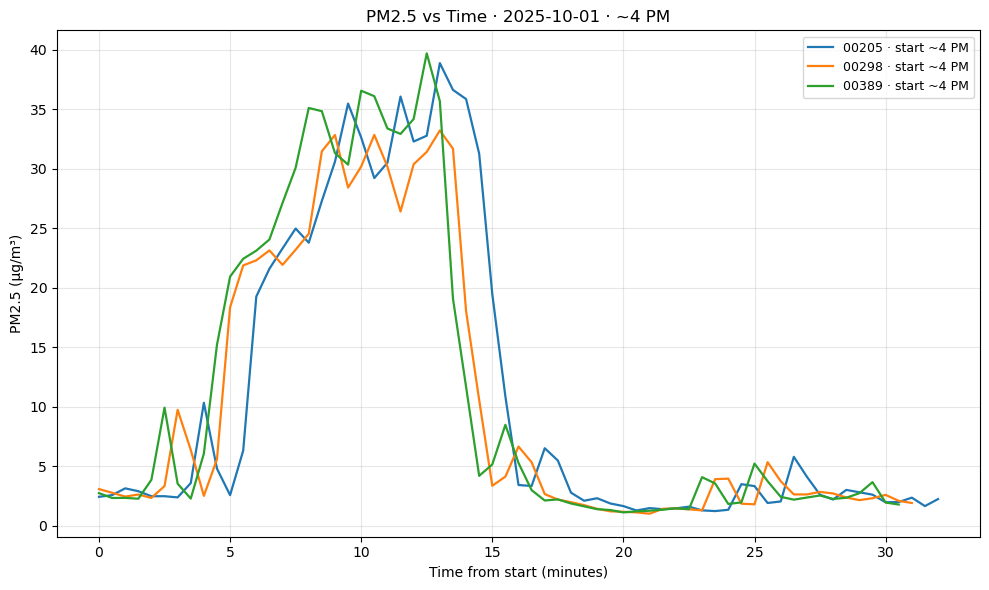

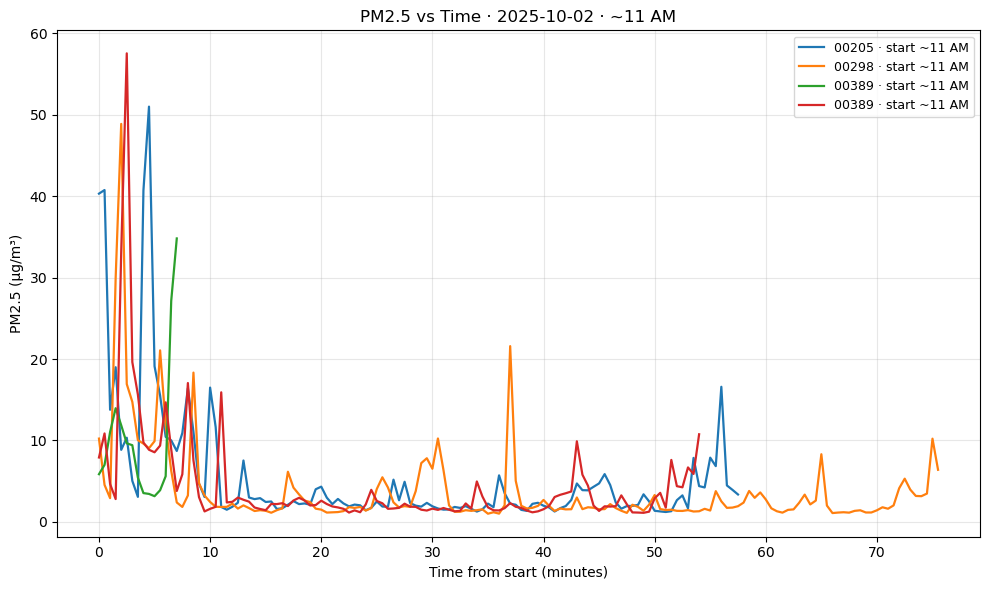

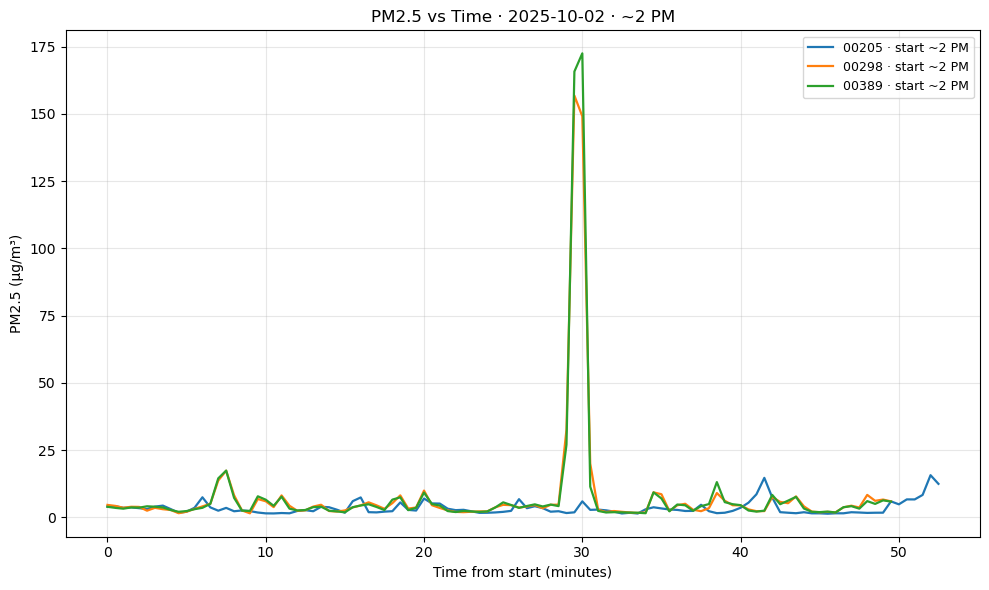

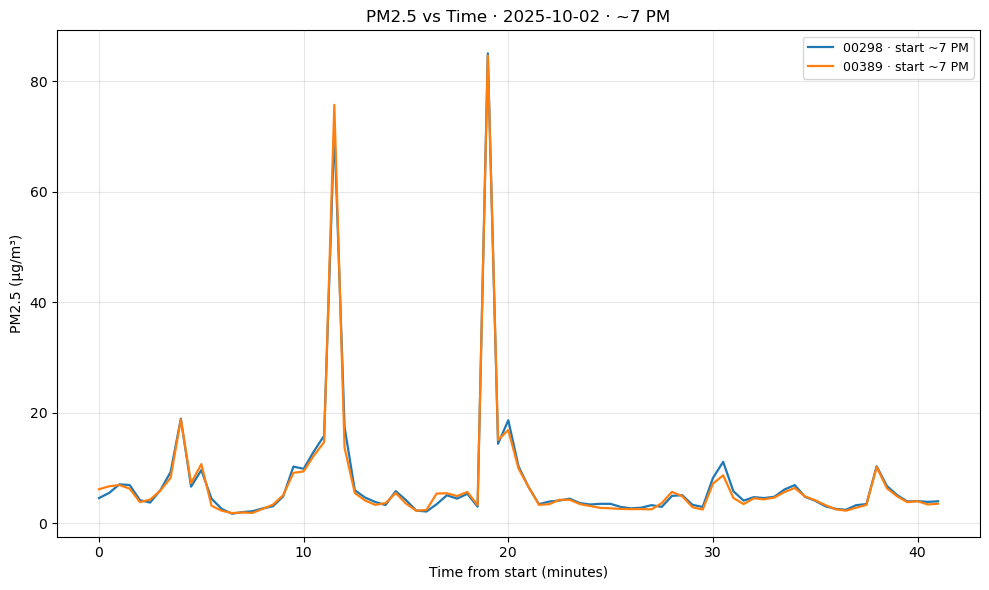


Generated 4 graphs
All processing done in memory - no files created!


In [44]:

# ============================================================================
# STEP 7: CREATE GRAPHS (DISPLAY ONLY, NO SAVING)
# ============================================================================

print("\nCreating graphs (displaying in notebook, not saving)...")

# Create one graph for each date and hour combination
for (date, hour), group in data.groupby(["date", "hour_bucket"], sort=True):
    
    plt.figure(figsize=(10, 6))
    
    # Plot each file/device on the same graph
    for filename, file_data in group.groupby("file"):
        device = file_data["device"].iloc[0]
        x = file_data["minutes"].to_numpy()
        y = file_data["pm25"].to_numpy()
        
        if len(x) == 0:
            continue
        
        # Sort by time
        order = np.argsort(x)
        x = x[order]
        y = y[order]
        
        # Plot line
        label = f"{device} · start ~{hour}"
        plt.plot(x, y, label=label, linewidth=1.6)
    
    # Format graph
    plt.xlabel("Time from start (minutes)")
    plt.ylabel("PM2.5 (µg/m³)")
    plt.title(f"PM2.5 vs Time · {date} · ~{hour}")
    plt.legend(loc="best", fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    # Display in notebook (no saving)
    plt.show()

print(f"\nGenerated {len(data.groupby(['date', 'hour_bucket']))} graphs")
print("All processing done in memory - no files created!")